## Imports

In [110]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time

##  Navier Stokes Equation

## Pure python

In [90]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
        
    cx = 1 / (2 * dt *dx)
    cy = 1 / (2 * dt *dy)
    #fill the update of b
    b[1:-1, 1:-1] = rho * (cx * (u[1:-1, 2:] - u[1:-1, 0:-2]) + cy * (v[2:, 1:-1] - v[0:-2, 1:-1]) \
                    - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 \
                    - ((u[2:, 1:-1] - u[0:-2, 1:-1]) / dy) * (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx) \
                    - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2)
    return b

def pressure_poisson_pure(p, dx, dy, b):
    cx = dx**2 / (2 * (dx**2 + dy**2))
    cy = dy**2 / (2 * (dx**2 + dy**2))
    c = (dx * dy)**2 / (2 * (dx**2 + dy**2))
    pn = np.empty_like(p)
    pn = p.copy()
    #fill the update of p
    for it in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = cx * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + cy * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) \
                        - c * b[1:-1,1:-1]
        #boundary conditions
        p[:, -1] = p[:, -2] 
        p[0, :] = p[1, :]   
        p[:, 0] = p[:, 1]   
        p[-1, :] = 0        
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    cx = dt / dx
    cx2 = nu * (dt / dx**2)
    cpx = dt / (2 * rho * dx)
    
    cy = dt / dy
    cy2 = nu * (dt / dy**2)
    cpy = dt / (2 * rho * dy) 
    
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    #fill the update of u and v
    for n in range(nt):
        un = u.copy()
        vn = v.copy()        
        b = build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_pure(p, dx, dy, b)
        u[1:-1, 1:-1] = un[1:-1, 1:-1] - cx * un[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) \
                        - cy * vn[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) \
                        - cpx * (p[1:-1, 2:] - p[1:-1, 0:-2]) \
                        + cx * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2])\
                        + cy * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])

        v[1:-1, 1:-1] = vn[1:-1, 1:-1] - cx * un[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) \
                        - cy * vn[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) \
                        - cpy * (p[2:, 1:-1] - p[0:-2, 1:-1]) \
                        + cx * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) \
                        + cy * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) 
        
        #initial conditions
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0       
        
        
    return u, v, p

## Numba accelerator

In [111]:
@njit(fastmath = True)
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
        
    cx = 1 / (2 * dt *dx)
    cy = 1 / (2 * dt *dy)
    #fill the update of b
    b[1:-1, 1:-1] = rho * (cx * (u[1:-1, 2:] - u[1:-1, 0:-2]) + cy * (v[2:, 1:-1] - v[0:-2, 1:-1]) \
                    - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 \
                    - ((u[2:, 1:-1] - u[0:-2, 1:-1]) / dy) * (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx) \
                    - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2)
    return b

@njit(fastmath = True)
def pressure_poisson_numba(p, dx, dy, b):
    cx = dx**2 / (2 * (dx**2 + dy**2))
    cy = dy**2 / (2 * (dx**2 + dy**2))
    c = (dx * dy)**2 / (2 * (dx**2 + dy**2))
    pn = np.empty_like(p)
    pn = p.copy()
    #fill the update of p
    for it in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = cx * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + cy * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) \
                        - c * b[1:-1,1:-1]
        #boundary conditions
        p[:, -1] = p[:, -2] 
        p[0, :] = p[1, :]   
        p[:, 0] = p[:, 1]   
        p[-1, :] = 0        
        
    return p

@njit(fastmath = True)
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    cx = dt / dx
    cx2 = nu * (dt / dx**2)
    cpx = dt / (2 * rho * dx)
    
    cy = dt / dy
    cy2 = nu * (dt / dy**2)
    cpy = dt / (2 * rho * dy) 
    
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    #fill the update of u and v
    for n in range(nt):
        un = u.copy()
        vn = v.copy()        
        b = build_up_b_numba(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_numba(p, dx, dy, b)
        u[1:-1, 1:-1] = un[1:-1, 1:-1] - cx * un[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) \
                        - cy * vn[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) \
                        - cpx * (p[1:-1, 2:] - p[1:-1, 0:-2]) \
                        + cx * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2])\
                        + cy * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])

        v[1:-1, 1:-1] = vn[1:-1, 1:-1] - cx * un[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) \
                        - cy * vn[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) \
                        - cpy * (p[2:, 1:-1] - p[0:-2, 1:-1]) \
                        + cx * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) \
                        + cy * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) 
        
        #initial conditions
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0       
        
        
    return u, v, p

## Inputs

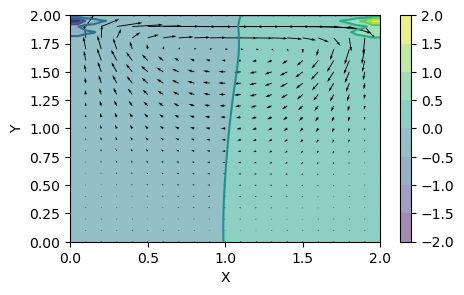

In [113]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

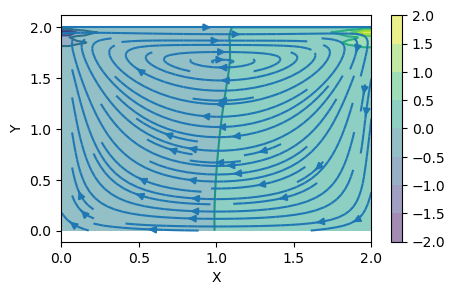

In [94]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Call Funtions

## Pure python function

In [95]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

1.15 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba accelerator

In [112]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

444 ms ± 9.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
